In [60]:
import glob
import io
from ipywidgets import interact
from ipywidgets import fixed
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import os
import openslide
from openslide import open_slide
from pathlib import Path
import pandas as pd
from PIL import Image, ImageOps, ImageChops
import seaborn as sns
import SimpleITK as sitk
from skimage.color import rgb2hed
from skimage.exposure import histogram
from skimage.filters import threshold_otsu
from skimage import morphology
from skimage.transform import rotate
import time
import warnings
import cv2

In [2]:
material_path = '/QRISdata/Q1851/Minh/RNAScope'
round1_dapi = '2020_05_05_R1_DAPI_TIFF/'
round2_dapi = '2020_05_06_R2_DAPI_TIFF'
dapi_1 = os.path.join(material_path, round1_dapi, '2020_05_05_R1_DAPI_TIFF_s1z1c4.tif')
dapi_2 = os.path.join(material_path, round2_dapi, '2020_05_06_R2_DAPI_TIFF_s1z1c3.tif')


In [25]:
def get_files_in_directory(directory, postfix=""):
    fileNames = [s for s in os.listdir(directory) if not os.path.isdir(os.path.join(directory, s))]
    if not postfix or postfix == "":
        return sorted(fileNames)
    else:
        return sorted([s for s in fileNames if s.lower().endswith(postfix)])
    
def get_files_in_dir_recursively(directory, postfix='json'):
    files = [file for file in glob.glob(os.path.join(directory, '**/*.{0}'.format(postfix)), recursive=True)]
    return files

def get_subdirectories_in_directory(directory, postfix=""):
    dir_names = [s for s in os.listdir(directory) if os.path.isdir(os.path.join(directory, s))]
    return sorted(dir_names)

def mkdirs(dirs):
    if not os.path.exists(dirs):
        os.makedirs(dirs)


def convert_original2scaled(x_coord, y_coord, scaled_size, original_size=original_czi1_size, exclude_rate_h=1.0, exclude_rate_w=1.0):
    return int(x_coord*scaled_size[0]/(original_size[0]*exclude_rate_w)), int(y_coord*scaled_size[1]/(original_size[1]*exclude_rate_h))


def list_to_int(list1D):
    return [int(float(x)) for x in list1D]

def draw_rectangles(img, rects, color=(0, 255, 255), thickness=7):
    clone_image = img.copy()
    for rect in rects:
        pt1 = tuple(list_to_int(rect[0:2]))
        pt2 = tuple(list_to_int(rect[2:]))
        cv2.rectangle(clone_image, pt1, pt2, color, thickness, cv2.FILLED)
    return clone_image

def get_xy_from_fn(fn):
    results = re.findall('x(\d+)_y(\d+)', fn)
    if len(results) == 1:
        x_coord, y_coord = results[0]
        x_coord, y_coord = int(x_coord), int(y_coord)
        return x_coord, y_coord, None
    else:
        x_coord, y_coord = results[-1]
        x_coord, y_coord = int(x_coord), int(y_coord)
        return x_coord, y_coord, [list_to_int(element) for element in results[:-1]]

def substite_file_name(file_name, pattern = 'Cy7',sub_string='Cy5'):
    output = re.sub(pattern, sub_string, file_name)
    return output 

def thumbnail(img, size = (1000,1000)):
    img_thumbnail = img.copy()
    img_thumbnail.thumbnail(size)
    return img_thumbnail

In [14]:
def get_itk_from_pil(pil_img):
    """Converts Pillow image into ITK image
    """
    return sitk.GetImageFromArray(np.array(pil_img))

def get_pil_from_itk(itk_img):
    """Converts ITK image into Pillow Image
    """
    return Image.fromarray(sitk.GetArrayFromImage(itk_img).astype(np.uint8))

def show_alignment(fixed_img, moving_img, prefilter = None):
    """Visualises alignment of fixed image with moving image
    
    Fixed image is displayed as blue
    Moving image is displayed as pink 
    """
    if prefilter == 'TP53':
        tp53_filtered = filter_green(moving_img)
        tp53_filtered = filter_grays(tp53_filtered, tolerance = 3)
        moving_img = filter_otsu_global(tp53_filtered, 'PIL')
        he_filtered = filter_green(fixed_img)
        he_filtered = filter_grays(he_filtered, tolerance = 15)
        fixed_img = filter_otsu_global(he_filtered, 'PIL')
    background = (255,255,255)
    img_red = ImageOps.colorize(moving_img.convert('L'), (255, 0, 0), background)
    img_blue = ImageOps.colorize(fixed_img.convert('L'), (0, 0, 255), background)
    img_red.putalpha(120)
    img_blue.putalpha(70)
    return Image.alpha_composite(img_red, img_blue)

def sitk_transform_rgb(moving_rgb_img, fixed_rgb_img, transform, interpolator = sitk.sitkLanczosWindowedSinc):
    """Applies a Simple ITK transform (e.g. Affine, B-spline) to an RGB image
    
    The transform is applied to each channel
    
    Parameters
    ----------
    moving_rgb_img : Pillow Image 
        This image will be transformed to produce the output image
    fixed_rgb_img : Pillow Image
        This reference image provides the output information (spacing, size, and direction) of the output image
    transform : SimpleITK transform
        Generated from image registration
    interpolator : SimpleITK interpolator
    
    Returns
    -------
    rgb_transformed : Pillow Image
        Transformed moving image 
    """
    transformed_channels = []
    r_moving, g_moving, b_moving, = moving_rgb_img.convert('RGB').split()
    r_fixed, g_fixed, b_fixed = fixed_rgb_img.convert('RGB').split()
    for moving_img, fixed_img in [(r_moving, r_fixed), (g_moving, g_fixed), (b_moving, b_fixed)]:
        moving_img_itk = get_itk_from_pil(moving_img)
        fixed_img_itk = get_itk_from_pil(fixed_img)
        transformed_img = sitk.Resample(moving_img_itk, fixed_img_itk, transform, 
                            interpolator, 0.0, moving_img_itk.GetPixelID())
        transformed_channels.append(get_pil_from_itk(transformed_img))
    rgb_transformed = Image.merge('RGB', transformed_channels)
    return rgb_transformed    

def start_plot():
    """Setup data for plotting
    
    Invoked when StartEvent happens at the beginning of registration.
    """
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

def end_plot():
    """Cleanup the data and figures 
    """
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show() 
    
def update_plot(registration_method):
    """Plot metric value after each registration iteration
    
    Invoked when IterationEvent happens.
    """
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number', fontsize=12)
    plt.ylabel('Metric', fontsize=12)
    plt.show()
    
def update_multires_iterations():
    """Update the index in the metric values list that corresponds to a change in registration resolution
    
    Invoked when the sitkMultiResolutionIterationEvent happens.
    """
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))
    
def plot_metric(title = 'Plot of registration metric vs iterations'):
    """Plots the mutual information over registration iterations
    
    Parameters
    ----------
    title : str
    
    Returns
    -------
    fig : matplotlib figure
    """
    global metric_values, multires_iterations
    
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_xlabel('Iteration Number', fontsize=12)
    ax.set_ylabel('Mutual Information Cost', fontsize=12)
    ax.plot(metric_values, 'r')
    ax.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*', label = 'change in resolution')
    ax.legend()
    return fig

################################
# Mutual Information Functions #
################################

def mutual_information(hgram):
    """Mutual information for joint histogram
    """
    # Convert bins counts to probability values
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis = 1) # marginal for x over y
    py = np.sum(pxy, axis = 0) # marginal for y over x
    px_py = px[:, None] * py[None, :] #Broadcat to multiply marginals
    # Now we can do the calculation using the pxy, px_py 2D arrays
    nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

def mutual_info_histogram(fixed_img, moving_img, bins = 20, log = False):
    hist_2d, x_edges, y_edges = np.histogram2d(fixed_img.ravel(), moving_img.ravel(), bins = bins)
    if log:
        hist_2d_log = np.zeros(hist_2d.shape)
        non_zeros = hist_2d != 0
        hist_2d_log[non_zeros] = np.log(hist_2d[non_zeros])
        return hist_2d_log
    return hist_2d

def plot_mutual_info_histogram(histogram):
    plt.imshow(histogram.T, origin = 'lower')
    plt.xlabel('Fixed Image')
    plt.ylabel('Moving Image')

def calculate_mutual_info(fixed_img, moving_img):
    hist = mutual_info_histogram(fixed_img, moving_img)
    return mutual_information(hist)

In [6]:
img_dapi1 = cv2.cvtColor(cv2.imread(dapi_1), cv2.COLOR_BGR2RGB)
img_dapi2 = cv2.cvtColor(cv2.imread(dapi_2), cv2.COLOR_BGR2RGB)
pil_img_dapi1 = Image.fromarray(img_dapi1)
pil_img_dapi2 = Image.fromarray(img_dapi2)

## General view
// CD207, NM_015717.5 – T1 channel -> FITC (green)

// Thy1, NM_001311160.2, T2 channel -> Cy3  (orange)

// IL34, NM_001172771.2, T3 channel -> Cy5 (far red)

// CSF1R, NM_001288705.2, T4 channel -> Cy7 (near Infrared)

// Itgam, NM_000632.4, T5 channel -> FITC (green)

// co-localized analysis CSF1R and IL34 

// co-localized analysis CD207 and Thy
## QuPath and post-process

1. Image registration to align Round 1 and Round 2
2. Evaluate the collocalization of IL34 and CSF1R (Round 1)
3. Evaluate the collocalization of ITGAM, Thy1 and CD207 (Round 1+2)
4. Extract tissue area only

In [7]:
dapi1_gray = pil_img_dapi1.convert('L')
dapi2_gray = pil_img_dapi2.convert('L')
dapi1_gray_itk = get_itk_from_pil(dapi1_gray)
dapi2_gray_itk = get_itk_from_pil(dapi2_gray)
fixed_img = dapi1_gray_itk
moving_img = dapi2_gray_itk

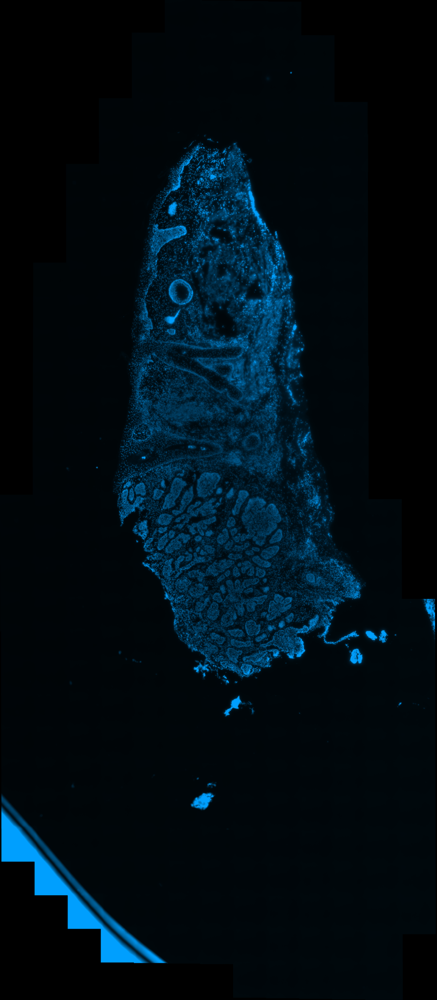

In [68]:
thumbnail(pil_img_dapi1)

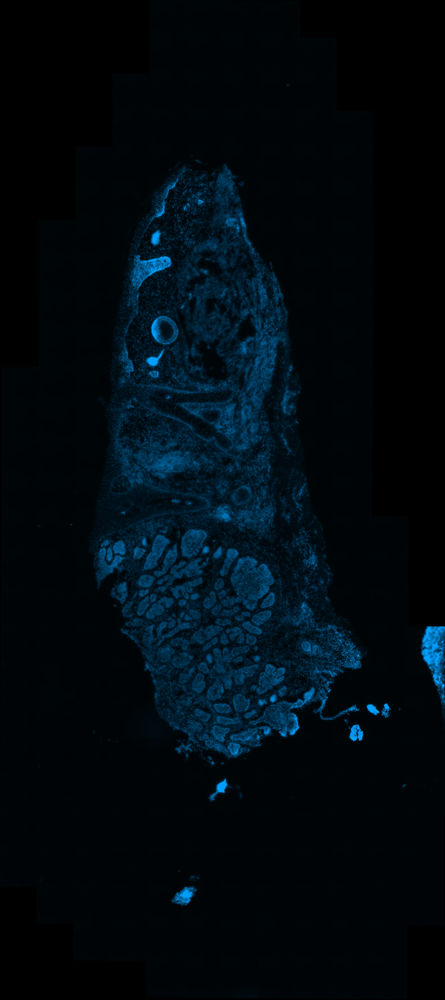

In [69]:
thumbnail(pil_img_dapi2)

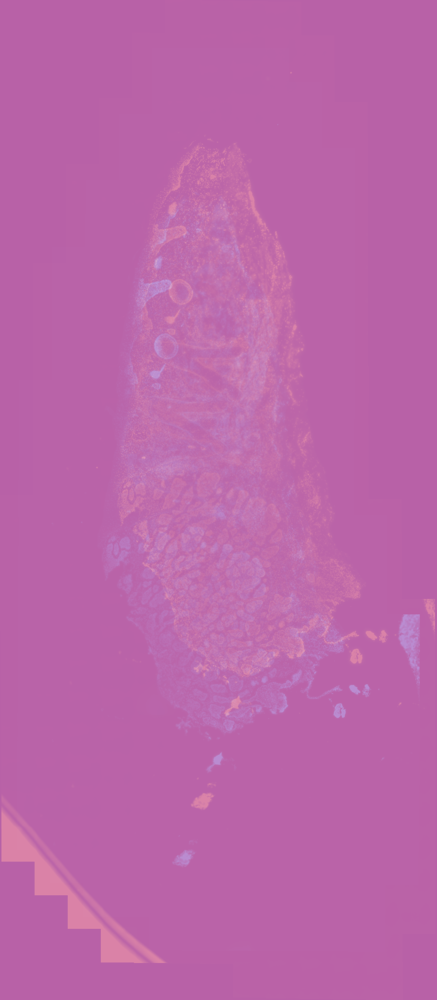

In [11]:
initial_transform = sitk.CenteredTransformInitializer(fixed_img, moving_img, sitk.Euler2DTransform(), sitk.CenteredTransformInitializerFilter.GEOMETRY)

moving_resampled = sitk.Resample(moving_img, fixed_img, initial_transform, sitk.sitkLinear, 0.0, moving_img.GetPixelID())

moving_rgb = sitk_transform_rgb(pil_img_dapi2, pil_img_dapi1, initial_transform)
thumbnail(show_alignment(pil_img_dapi1, moving_rgb, prefilter = True))

In [12]:
calculate_mutual_info(np.array(dapi1_gray), np.array(get_pil_from_itk(moving_resampled)))

0.20768385732963932

## Affine + B-Spline Registration

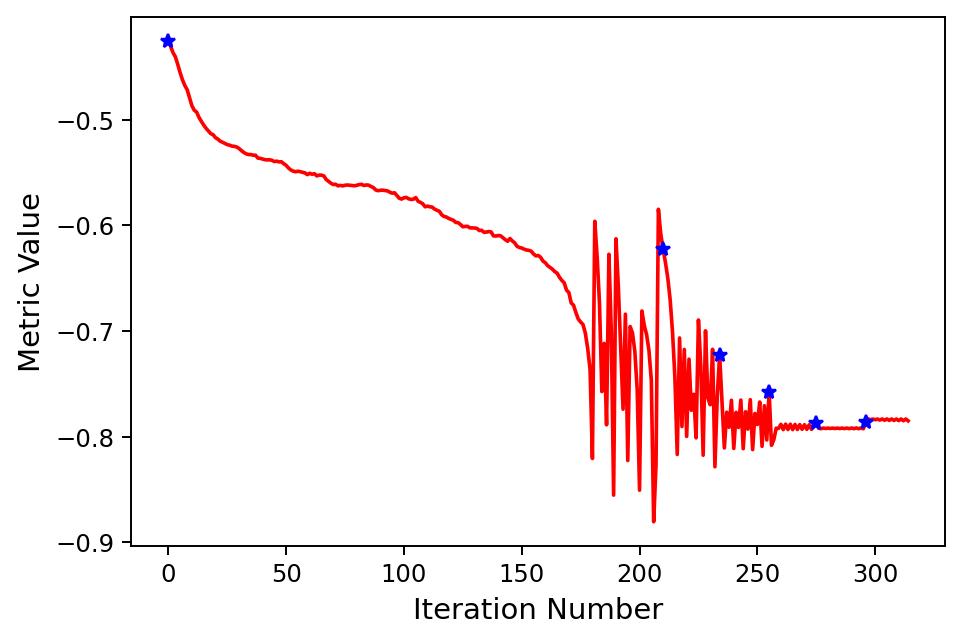

Affine metric value: -0.7831426382368087
Affine Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 19.


In [15]:
initial_transform = sitk.CenteredTransformInitializer(fixed_img, moving_img, sitk.Euler2DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)
affine_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
affine_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=75)
affine_method.SetMetricSamplingStrategy(affine_method.RANDOM)
affine_method.SetMetricSamplingPercentage(0.15)

affine_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
affine_method.SetOptimizerAsGradientDescent(learningRate=1, numberOfIterations=300, convergenceMinimumValue=1e-6, convergenceWindowSize=20)
affine_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.      
# registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [16,8,4,2,1])
# registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[10,4,2,1,0])
affine_method.SetShrinkFactorsPerLevel(shrinkFactors = [16,8,4,3,2,1])
affine_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[10,4,3,2,1,0])
affine_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
affine_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
affine_method.AddCommand(sitk.sitkStartEvent, start_plot)
affine_method.AddCommand(sitk.sitkEndEvent, end_plot)
affine_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
affine_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(affine_method))

affine_transform = affine_method.Execute(sitk.Cast(fixed_img, sitk.sitkFloat32), 
                                               sitk.Cast(moving_img, sitk.sitkFloat32))

print('Affine metric value: {0}'.format(affine_method.GetMetricValue()))
print('Affine Optimizer\'s stopping condition, {0}'.format(affine_method.GetOptimizerStopConditionDescription()))

In [16]:
moving_resampled_affine = sitk.Resample(moving_img, fixed_img, affine_transform, 
                                 sitk.sitkLinear, 0.0, moving_img.GetPixelID())
calculate_mutual_info(np.array(dapi1_gray), np.array(get_pil_from_itk(moving_resampled_affine)))

0.4772689601409159

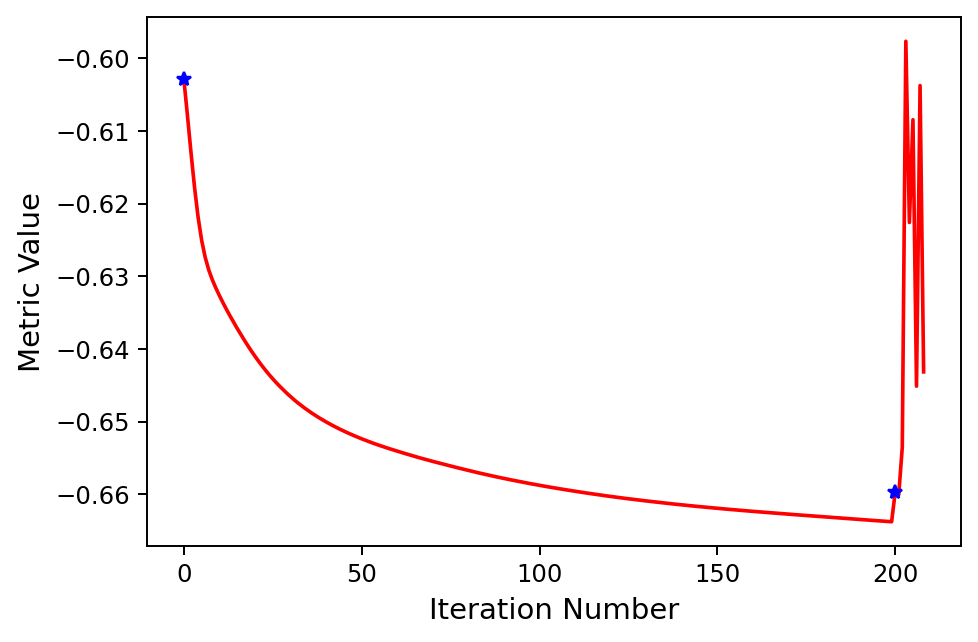

BSpline metric value: -0.585875437844865
BSpline Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 9.


In [17]:
bspline_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
bspline_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
bspline_method.SetMetricSamplingStrategy(bspline_method.RANDOM)
bspline_method.SetMetricSamplingPercentage(0.15)

bspline_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
bspline_method.SetOptimizerAsGradientDescent(learningRate=1, numberOfIterations=200, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
bspline_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.            
bspline_method.SetShrinkFactorsPerLevel(shrinkFactors = [2,1])
bspline_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[1,0])
bspline_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
transformDomainMeshSize = [8]*moving_resampled_affine.GetDimension()
initial_transform = sitk.BSplineTransformInitializer(fixed_img, transformDomainMeshSize)
bspline_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
bspline_method.AddCommand(sitk.sitkStartEvent, start_plot)
bspline_method.AddCommand(sitk.sitkEndEvent, end_plot)
bspline_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
bspline_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(bspline_method))

bspline_transform = bspline_method.Execute(sitk.Cast(fixed_img, sitk.sitkFloat32), 
                                               sitk.Cast(moving_resampled_affine, sitk.sitkFloat32))

print('BSpline metric value: {0}'.format(bspline_method.GetMetricValue()))
print('BSpline Optimizer\'s stopping condition, {0}'.format(bspline_method.GetOptimizerStopConditionDescription()))

In [18]:
moving_resampled_final_4 = sitk.Resample(moving_resampled_affine, fixed_img, bspline_transform, 
                                 sitk.sitkLinear, 0.0, moving_img.GetPixelID())
calculate_mutual_info(np.array(dapi1_gray), np.array(get_pil_from_itk(moving_resampled_final_4)))

0.4583444210094669

In [19]:
moving_rgb_affine = sitk_transform_rgb(pil_img_dapi2, pil_img_dapi1, affine_transform)
moving_rgb_final_4 = sitk_transform_rgb(moving_rgb_affine, pil_img_dapi1, bspline_transform)
# thumbnail(show_alignment(he, moving_rgb_final, prefilter = True))
# moving_rgb_final_3 = sitk_transform_rgb(pil_img_dapi2, pil_img_dapi1, bspline_transform)
print(moving_rgb_final_4.size)
change_color_mv_rgb_final_4 = np.array(moving_rgb_final_4)
print(change_color_mv_rgb_final_4.shape)
foreground = Image.fromarray(cv2.cvtColor(change_color_mv_rgb_final_4, cv2.COLOR_BGR2RGB))
background = pil_img_dapi1

(7859, 17989)
(17989, 7859, 3)


In [21]:
def overlay_pil_imgs(foreground, background, best_loc = (0,0), alpha=0.5):
    newimg1 = Image.new('RGBA', size=background.size, color=(0, 0, 0, 0))
    newimg1.paste(foreground, best_loc)
    newimg1.paste(background, (0, 0))

    newimg2 = Image.new('RGBA', size=background.size, color=(0, 0, 0, 0))
    newimg2.paste(background, (0, 0))
    newimg2.paste(foreground, best_loc)
    result = Image.blend(newimg1, newimg2, alpha=alpha)
    return result

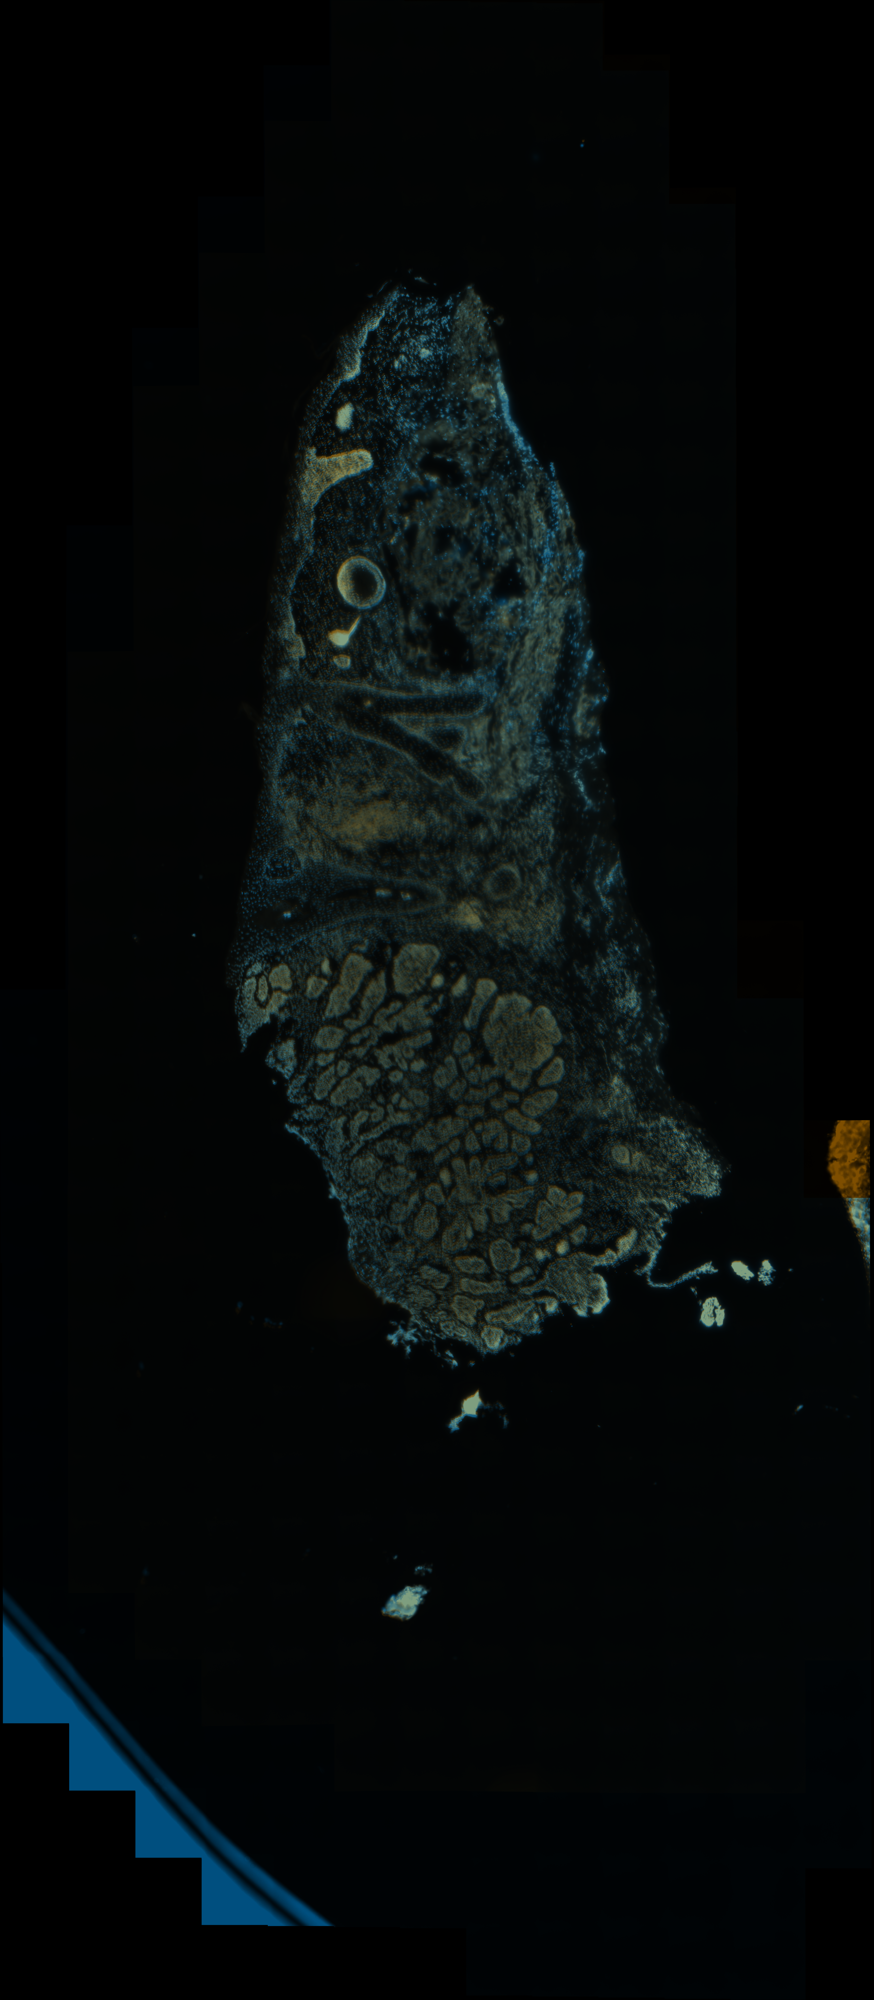

In [22]:
overlayed_imgs_4 = overlay_pil_imgs(background=background, foreground=foreground, alpha=0.5)
thumbnail(overlayed_imgs_4, size = (2000,2000))

In [23]:
print(affine_transform)

itk::simple::Transform
 CompositeTransform (0x56032580a490)
   RTTI typeinfo:   itk::CompositeTransform<double, 2u>
   Reference Count: 1
   Modified Time: 122901991
   Debug: Off
   Object Name: 
   Observers: 
     none
   Transforms in queue, from begin to end:
   >>>>>>>>>
   Euler2DTransform (0x56030b49d420)
     RTTI typeinfo:   itk::Euler2DTransform<double>
     Reference Count: 1
     Modified Time: 122901200
     Debug: Off
     Object Name: 
     Observers: 
       none
     Matrix: 
       0.999991 -0.00429898 
       0.00429898 0.999991 
     Offset: [-558.871, 103.545]
     Center: [3929, 8994]
     Translation: [-597.572, 120.353]
     Inverse: 
       0.999991 0.00429898 
       -0.00429898 0.999991 
     Singular: 0
     Angle       = 0.004299
   End of MultiTransform.
<<<<<<<<<<
   TransformsToOptimizeFlags, begin() to end(): 
      1 
   TransformsToOptimize in queue, from begin to end:
   End of TransformsToOptimizeQueue.
<<<<<<<<<<
   End of CompositeTransform.
<<<<

In [39]:
original_czi1_size = (54513, 23814)
original_czi2_size = (14778, 38361)
original_czi3_size = (12890, 20217)
original_czi4_size = (14870, 34710)
#-----------------------------------------------------------
original_czi1_size_s2 = (49329, 21951)
original_czi2_size_s2 = (18361, 45640)

original_czi3_size_s2 = (14792, 32812)
original_czi4_size_s2 = (14870, 34710)

#-----------------------------------------------------------
mu_metric1_s2 = (9015.96, 3567.04)
mu_metric2_s2 = (3284.13, 9105.20)
# mu_metric3_s2 = (2430.70, 5331.95)
# mu_metric4_s2 = (3107.63, 7976.64)

big_window = 0.1
medium_window = 0.25*0.1
small_window = 0.5*medium_window
qupath_output = '/QRISdata/Q1851/Minh/RNAScope/QuPath_project_1/'


In [29]:
scene1_output_dir = os.path.join(qupath_output, 'Scene_1')
list_output_files1 = get_files_in_dir_recursively(scene1_output_dir)
print(len(list_output_files1))
list_output_files1 = np.array(list_output_files1)

6224


In [44]:
all_rects = list()
recorded_parent_boxes = list()
for fn in list_output_files1:
    if 'DAPI' in fn:
        x_coord, y_coord, parent_annots = get_xy_from_fn(fn)
        if parent_annots is not None:
#             pass
#             for index, parent_annot in enumerate(parent_annots):
#                 if parent_annot not in recorded_parent_boxes:
#                     x_par, y_par = parent_annot
#                     annot_x, annot_y = convert_original2scaled(x_par, 
#                                                                y_par, 
#                                                                (img_dapi1.shape[0], img_dapi1.shape[1]),
#                                                                original_czi1_size)
#                     if index == 0:
#                         rect = [annot_x, 
#                                 annot_y, 
#                                 annot_x+int(big_window*img_dapi1.shape[1]),
#                                 annot_y+int(big_window*img_dapi1.shape[0]*0.8)]
#                         all_rects.append(rect)
#                         recorded_parent_boxes.append(parent_annot)
#                     elif index == 1:
#                         rect = [annot_x, 
#                                 annot_y, 
#                                 annot_x+int(medium_window*img_dapi1.shape[1]),
#                                 annot_y+int(medium_window*img_dapi1.shape[0]*0.8)]
#                         all_rects.append(rect)
#                         recorded_parent_boxes.append(parent_annot)
            annot_x, annot_y = convert_original2scaled(x_coord, 
                                                       y_coord, 
                                                       (img_dapi1.shape[0], img_dapi1.shape[1]), 
                                                       original_czi1_size)
            if len(parent_annots) == 1:
                ratio = medium_window
            else:
                ratio = small_window
                
            rect = [annot_x, 
                    annot_y, 
                    annot_x+int(ratio*img_dapi1.shape[1]),
                    annot_y+int(ratio*img_dapi1.shape[0]*0.8)]
            all_rects.append(rect)
#         else:
#             annot_x, annot_y = convert_original2scaled(x_coord, 
#                                                        y_coord, 
#                                                        (img_dapi1.shape[0], img_dapi1.shape[1]), 
#                                                        original_czi1_size)
#             rect = [annot_x, 
#                     annot_y, 
#                     annot_x+int(big_window*img_dapi1.shape[1]),
#                     annot_y+int(big_window*img_dapi1.shape[0]*0.8)]
#             all_rects.append(rect)



In [34]:
scene2_output_dir = os.path.join(qupath_output, 'Scene_1_R2')
list_output_files2 = get_files_in_dir_recursively(scene2_output_dir)
print(len(list_output_files2))
list_output_files2 = np.array(list_output_files2)

5022


In [48]:
all_rects2 = list()
recorded_parent_boxes2 = list()
for fn in list_output_files2:
    if 'DAPI' in fn:
        x_coord, y_coord, parent_annots = get_xy_from_fn(fn)
        if parent_annots is not None:
#             pass
#             for index, parent_annot in enumerate(parent_annots):
#                 if parent_annot not in recorded_parent_boxes2:
#                     x_par, y_par = parent_annot
#                     annot_x, annot_y = convert_original2scaled(x_par, 
#                                                                y_par, 
#                                                                (img_dapi2.shape[0], img_dapi2.shape[1]),
#                                                                original_czi1_size_s2)
#                     if index == 0:
#                         rect = [annot_x, 
#                                 annot_y, 
#                                 annot_x+int(big_window*img_dapi2.shape[1]),
#                                 annot_y+int(big_window*img_dapi2.shape[0]*0.8)]
#                         all_rects2.append(rect)
#                         recorded_parent_boxes2.append(parent_annot)
#                     elif index == 1:
#                         rect = [annot_x, 
#                                 annot_y, 
#                                 annot_x+int(medium_window*img_dapi2.shape[1]),
#                                 annot_y+int(medium_window*img_dapi2.shape[0]*0.8)]
#                         all_rects2.append(rect)
#                         recorded_parent_boxes2.append(parent_annot)
            annot_x, annot_y = convert_original2scaled(x_coord, 
                                                       y_coord, 
                                                       (img_dapi2.shape[0], img_dapi2.shape[1]), 
                                                       original_czi1_size_s2)
            if len(parent_annots) == 1:
                ratio = medium_window
            else:
                ratio = small_window
                
            rect = [annot_x, 
                    annot_y, 
                    annot_x+int(ratio*img_dapi1.shape[1]),
                    annot_y+int(ratio*img_dapi1.shape[0]*0.8)]
            all_rects2.append(rect)
#         else:
#             annot_x, annot_y = convert_original2scaled(x_coord, 
#                                                        y_coord, 
#                                                        (img_dapi2.shape[0], img_dapi2.shape[1]), 
#                                                        original_czi1_size_s2)
#             rect = [annot_x, 
#                     annot_y, 
#                     annot_x+int(big_window*img_dapi2.shape[1]),
#                     annot_y+int(big_window*img_dapi2.shape[0]*0.8)]
#             all_rects2.append(rect)



1555


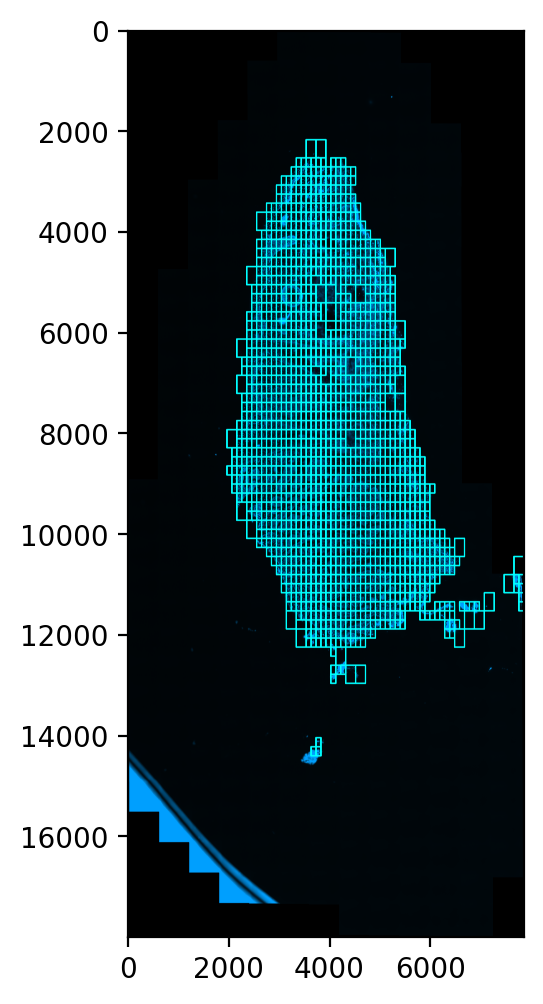

In [45]:
demo_image = draw_rectangles(img_dapi1, all_rects, thickness=30)
print(len(all_rects))
plt.figure(num=None, figsize=(8, 6), dpi=200, facecolor='w', edgecolor='k')
plt.imshow(demo_image, vmax=255, vmin=0)
plt.savefig('All_annotation_visualize')

1673


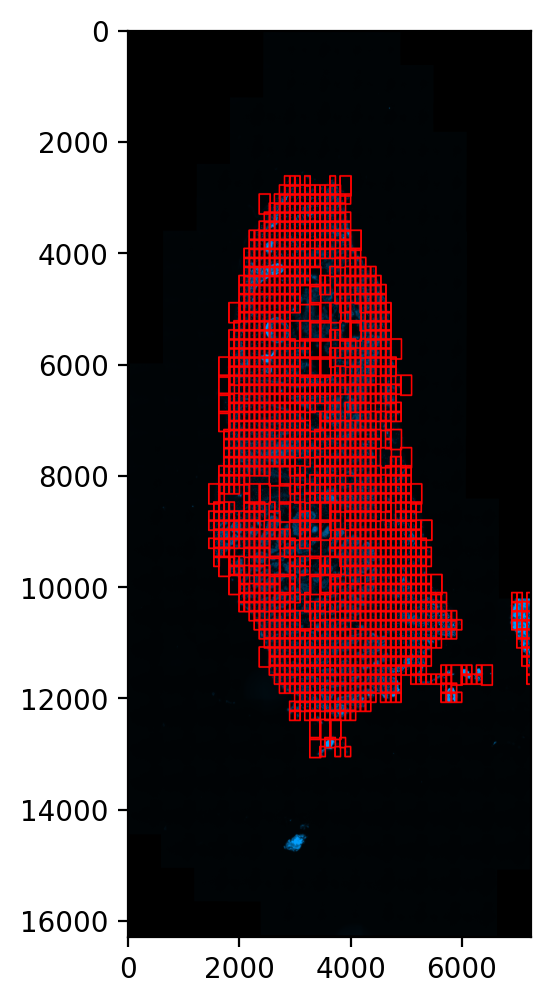

In [49]:
demo_image2 = draw_rectangles(img_dapi2, all_rects2, color=[255, 0, 0], thickness=30)
print(len(all_rects2))
plt.figure(num=None, figsize=(8, 6), dpi=200, facecolor='w', edgecolor='k')
plt.imshow(demo_image2, vmax=255, vmin=0)
plt.savefig('All_annotation_visualize')

(7859, 17989)
(17989, 7859, 3)


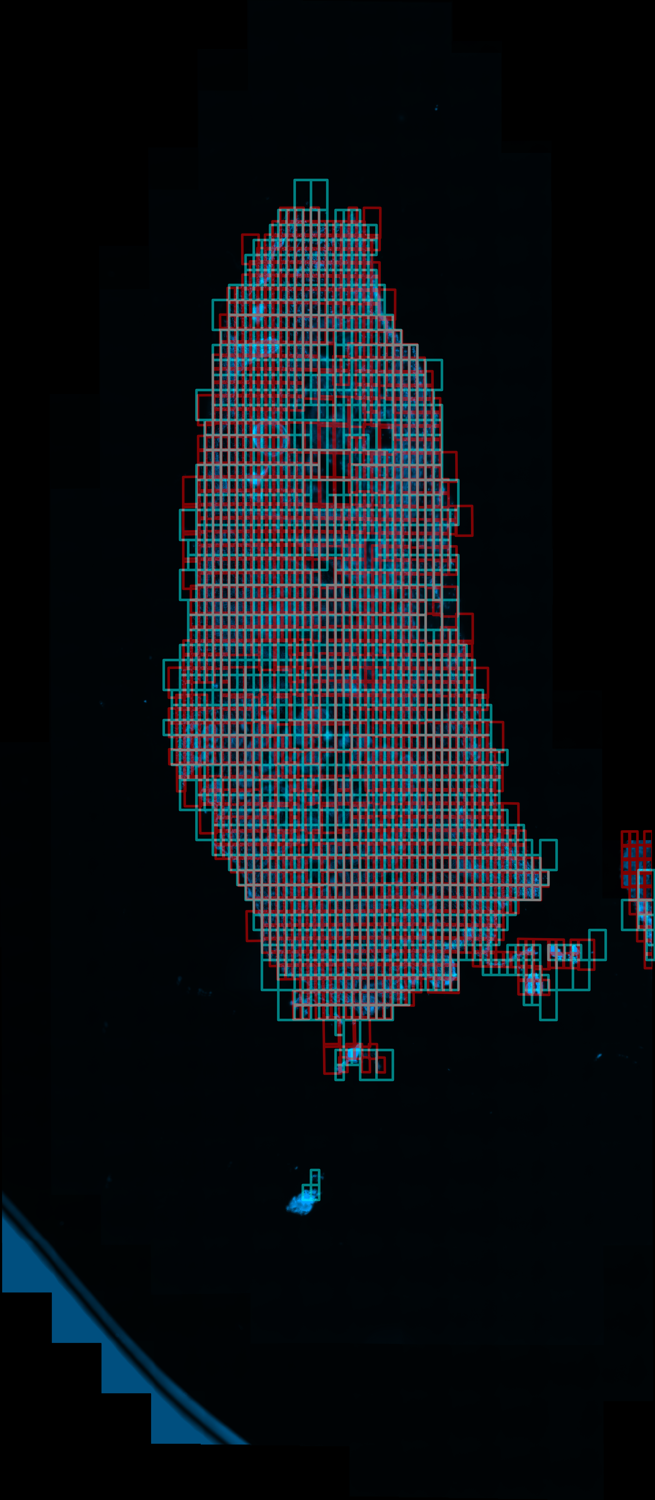

In [52]:
annotated_1 = Image.fromarray(demo_image)
annotated_2 = Image.fromarray(demo_image2)

moving_annot_affine = sitk_transform_rgb(annotated_2, annotated_1, affine_transform)
moving_annot_final = sitk_transform_rgb(moving_annot_affine, annotated_1, bspline_transform)
# thumbnail(show_alignment(he, moving_rgb_final, prefilter = True))
# moving_rgb_final_3 = sitk_transform_rgb(pil_img_dapi2, pil_img_dapi1, bspline_transform)
print(moving_annot_final.size)
change_moving_annot_final = np.array(moving_annot_final)
print(change_moving_annot_final.shape)
foreground = Image.fromarray(change_moving_annot_final)
background = annotated_1

overlayed_annot = overlay_pil_imgs(background=background, foreground=foreground, alpha=0.5)
thumbnail(overlayed_annot, size = (1500,1500))

In [55]:
def map_heat_values2colors(values):
    colors = list()
#     count = 0
    sorted_values = np.sort(values, kind='mergesort')
    set_box_scores = list(OrderedDict.fromkeys(sorted_values).keys())
    heat_colors_range = sns.color_palette('viridis', len(set_box_scores))
    for value in values:
        if value == 0:
            raw_color = [0,0,0]
        else:
            raw_color = heat_colors_range[set_box_scores.index(value)]
        colors.append(raw_color)
#         if set_box_scores.index(value) > 49:
#             count+= 1
#     print(count)
    return np.array(colors)

def draw_rectangles_heat(img, rects, colors, scores):
    clone_image = img.copy()
    for index, rect in enumerate(rects):
        pt1 = tuple(list_to_int(rect[0:2]))
        pt2 = tuple(list_to_int(rect[2:]))
        cv2.rectangle(clone_image, pt1, pt2, colors[index], cv2.FILLED)
#         print(scores[index])
#         cv2.putText(clone_image, str(scores[index]), tuple((pt1[0], pt1[1])), cv2.FONT_HERSHEY_SIMPLEX, 
#                     50, color=(255,255,255))
    return clone_image

def collocalize_score(fn):
    equivalent_cy7_fn = substite_file_name(fn, 'DAPI', 'Cy7')
    equivalent_cy5_fn = substite_file_name(fn, 'DAPI', 'Cy5')
    with open(fn) as json_file:
        dapi_json = json.load(json_file)
    cell_counts = len(dapi_json)
    if os.path.exists(equivalent_cy7_fn) and os.path.exists(equivalent_cy5_fn):
        try:
            with open(equivalent_cy7_fn) as json_file:
                cy7_json = json.load(json_file)
            present_cy7 = len(cy7_json)
        except:
            present_cy7 = 0
        try: 
            with open(equivalent_cy5_fn) as json_file:
                cy5_json = json.load(json_file)
            present_cy5 = len(cy5_json)
        except: 
            present_cy5 = 0  
    if present_cy5 == 0 or present_cy7 == 0:
        return 0
#     if (present_cy5+present_cy7)/cell_counts > 5:
#         print(present_cy5, present_cy7, cell_counts)
    return (present_cy5+present_cy7)/cell_counts

def normalize_score_by_rect(score, rect):
    area = abs(rect[2] - rect[0])*abs(rect[3]-rect[1])
    return score

In [62]:
all_collocalized_rects = list()

box_collocalized_scores = list()
child_count = dict()

for fn in list_output_files:
    if 'DAPI' in fn:
        x_coord, y_coord, parent_annots = get_xy_from_fn(fn)
        if parent_annots is not None:
            for index, parent_annot in enumerate(parent_annots):
                if child_count.get('_'.join(str(i) for i in parent_annot), None) is None:
                    
                    x_par, y_par = parent_annot
                    annot_x, annot_y = convert_original2scaled(x_par, y_par, 
                                                               (img_dapi1.shape[0], img_dapi1.shape[1]), 
                                                               original_czi1_size)
                    if index == 0:
                        par_rect = [annot_x, 
                                    annot_y, 
                                    annot_x+int(big_window*img_dapi1.shape[1]),
                                    annot_y+int(big_window*img_dapi1.shape[0]*0.8)]
                    elif index == 1:
                        par_rect = [annot_x, 
                                    annot_y, 
                                    annot_x+int(medium_window*img_dapi1.shape[1]),
                                    annot_y+int(medium_window*img_dapi1.shape[0]*0.8)]
                    all_collocalized_rects.append(par_rect)
#                     score = collocalize_score(fn)
                    child_count['_'.join(str(i) for i in parent_annot)] = 1
                    box_collocalized_scores.append(0)

                else:
                    child_count['_'.join(str(i) for i in parent_annot)] += 1
                    annot_x, annot_y = convert_original2scaled(x_coord, y_coord, 
                                                               (img_dapi1.shape[0], img_dapi1.shape[1]), 
                                                               original_czi1_size)
                    if len(parent_annots) == 1:
                        ratio = medium_window
                    elif len(parent_annots) == 2:
                        ratio = small_window
                    rect = [annot_x, 
                            annot_y, 
                            annot_x+int(ratio*img_dapi1.shape[1]),
                            annot_y+int(ratio*img_dapi1.shape[0]*0.8)]
                    all_collocalized_rects.append(rect)
                    score = collocalize_score(fn)
#                     if score > 4:
#                         print(score, rect)
#                         print(fn)
                    box_collocalized_scores.append(normalize_score_by_rect(score, rect))
        else:
            annot_x, annot_y = convert_original2scaled(x_coord, y_coord, 
                                                       (img_dapi1.shape[0], img_dapi1.shape[1]), 
                                                       original_czi1_size)
            rect = [annot_x, 
                    annot_y, 
                    annot_x+int(big_window*img_dapi1.shape[1]),
                    annot_y+int(big_window*img_dapi1.shape[0]*0.8)]
            all_collocalized_rects.append(rect)
#             score = collocalize_score(fn)
            box_collocalized_scores.append(0)


box_collocalized_scores = np.array(box_collocalized_scores)
# std_scaler = StandardScaler()
# stded_box_score = std_scaler.fit_transform(box_collocalized_scores.reshape(-1,1))
# print(stded_box_score.mean(), stded_box_score.std())
# print(stded_box_score.reshape(box_collocalized_scores.shape))
heat_colors = np.array(map_heat_values2colors(box_collocalized_scores))
# print(heat_colors[10:25])
heat_colors = heat_colors * 255
# print(heat_colors[10:25])
heat_demo_image = draw_rectangles_heat(np.zeros_like(img_dapi1), all_collocalized_rects, heat_colors, box_collocalized_scores)



0.0 7.75


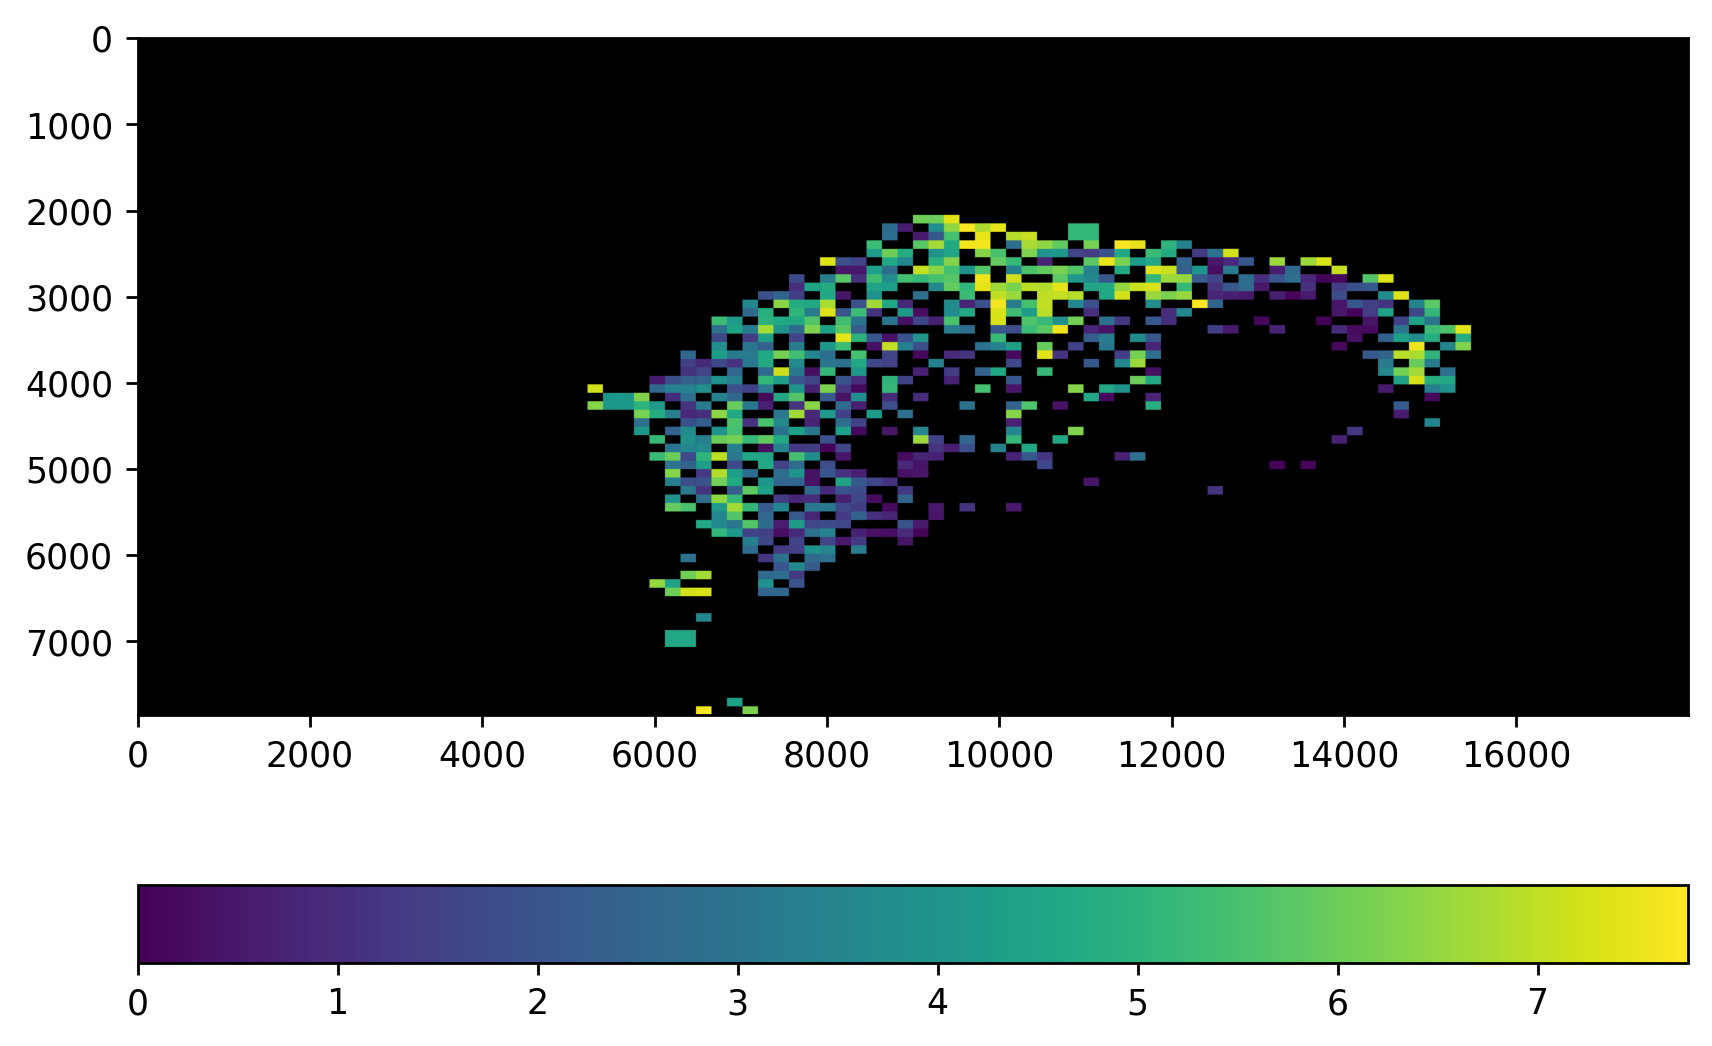

In [67]:
print(box_collocalized_scores.min(), box_collocalized_scores.max())
rotated_heat_demo_image = rotate(heat_demo_image, -90, resize=True)

plt.figure(num=None, figsize=(8, 6), dpi=250, facecolor='w', edgecolor='k')
plt.imshow(rotated_heat_demo_image, vmax=box_collocalized_scores.min(), vmin=box_collocalized_scores.max())
plt.colorbar(orientation='horizontal')
plt.savefig('collocalization_heatmap_normalized_cell_count_scene1.pdf')


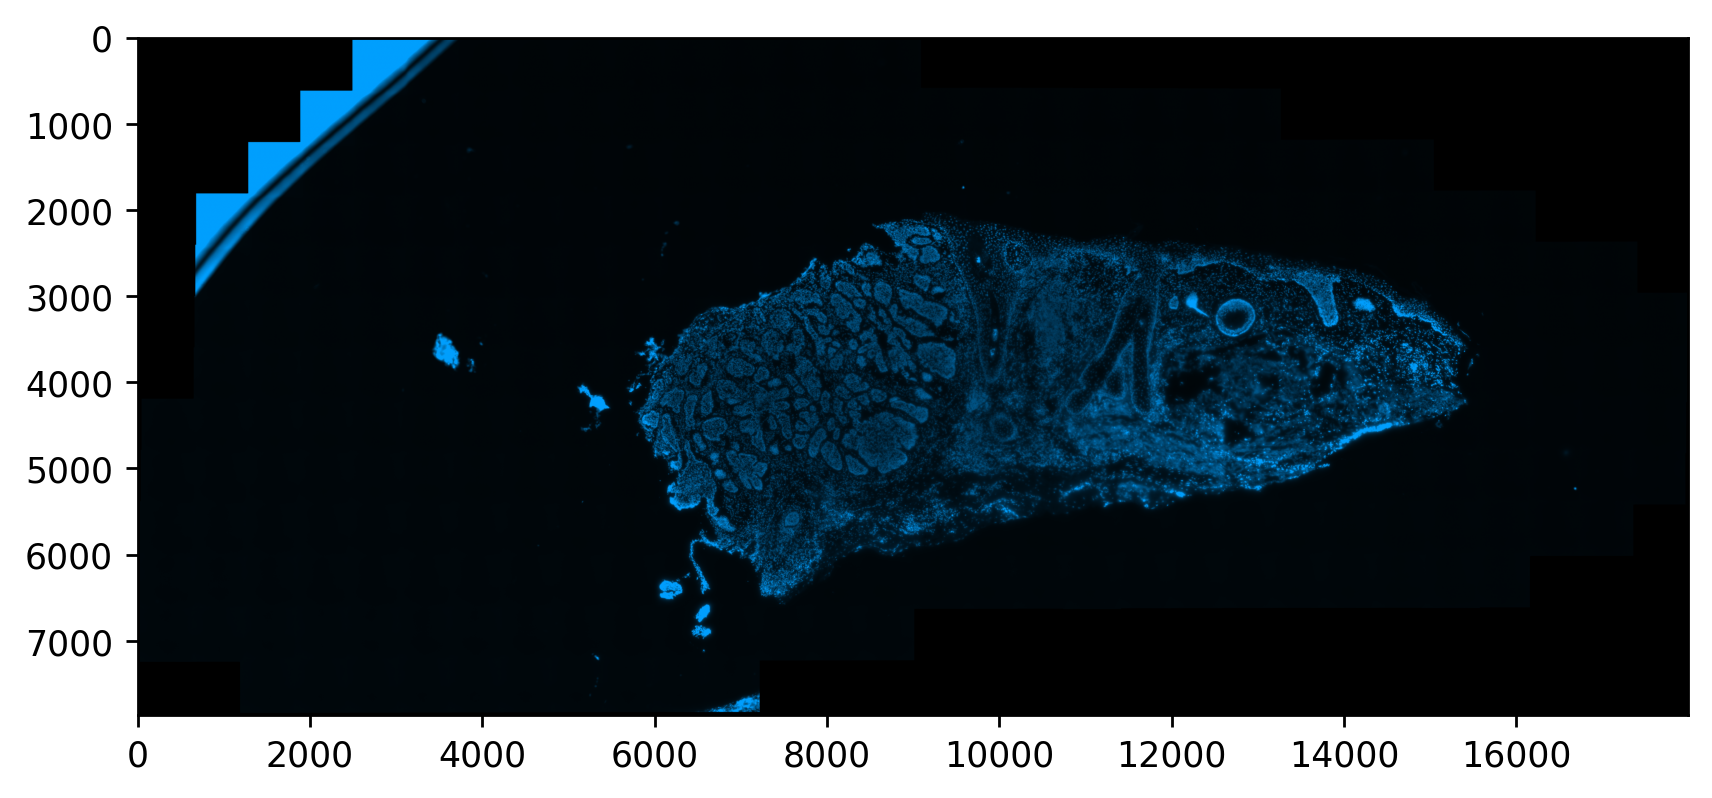

In [64]:
rotated_dapi1 = rotate(img_dapi1, -90, resize=True)
plt.figure(num=None, figsize=(8, 6), dpi=250, facecolor='w', edgecolor='k')
plt.imshow(rotated_dapi1)
# plt.colorbar()
# plt.savefig('collocalization_heatmap_normalized_cell_count_scene1.pdf')

### Draw contour line


In [70]:
# from skimage.data import astronaut
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

In [73]:
def y_element(element):
    return element[0]
def x_element(element):
    return element[1]
def xy_element(element):
    return element[0]+ element[1]

all_rects.sort(key=x_element)
select_rects = all_rects[:-10]
select_rects.sort(key=y_element)
select_rects = select_rects[:-15]
select_rects.sort(key=xy_element)
select_rects = select_rects[:-5]

1525


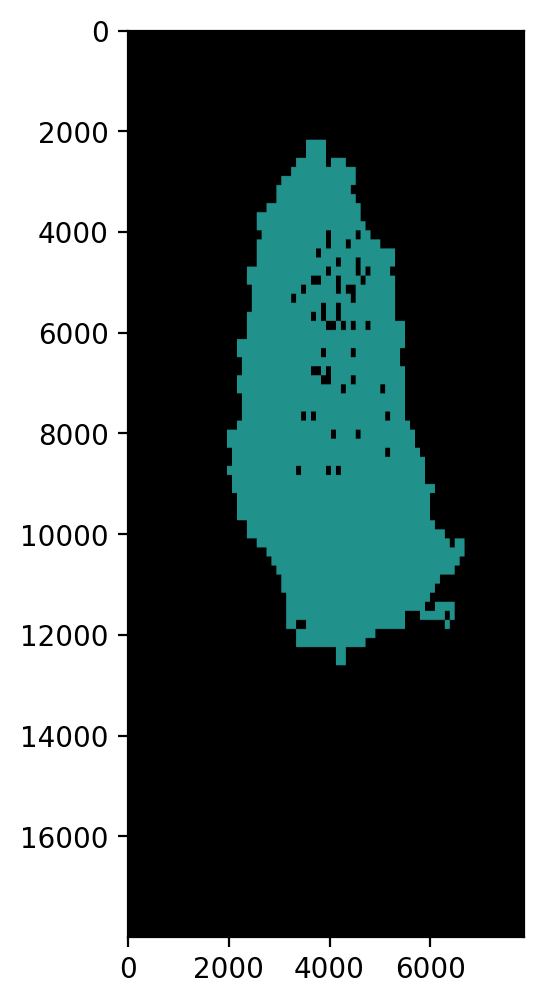

In [74]:
mask_dapi = np.zeros_like(img_dapi1)

box_collocalized_scores_2 = list()
for rect in select_rects:
    box_collocalized_scores_2.append(2)

mask_colors = np.array(map_heat_values2colors(box_collocalized_scores_2))
# print(heat_colors[10:25])
mask_colors = mask_colors * 255

mask_by_dapi = draw_rectangles_heat(mask_dapi, select_rects, mask_colors, box_collocalized_scores_2)
print(len(select_rects))
plt.figure(num=None, figsize=(8, 6), dpi=200, facecolor='w', edgecolor='k')
plt.imshow(mask_by_dapi, vmax=255, vmin=0)
# plt.savefig('All_annotation_visualize')

In [75]:
# Find contours at a constant value of 0.8
from skimage import measure
gray_all = cv2.cvtColor(mask_by_dapi, cv2.COLOR_RGB2GRAY)
contours = measure.find_contours(gray_all, 0.8)

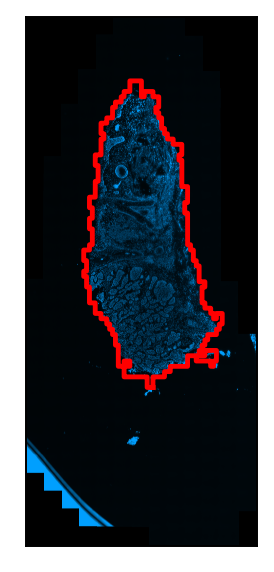

In [77]:
fig, ax = plt.subplots()
# ax.imshow(np.zeros_like(mask_by_dapi), cmap=plt.cm.gray)
ax.imshow(img_dapi1, cmap=plt.cm.gray)

for n, contour in enumerate(contours[0:1]):
    ax.plot(contour[:, 1], contour[:, 0], 'r',linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [81]:
from scipy import ndimage as ndi
mask_binary = np.zeros_like(cv2.cvtColor(mask_by_dapi, cv2.COLOR_RGB2GRAY))
mask_binary[np.round(contours[0][:, 0]).astype('int'), np.round(contours[0][:, 1]).astype('int')] = 1
fill_contour = ndi.binary_fill_holes(mask_binary)
fill_contour = fill_contour.astype('int')
# plt.imshow(np.array(fill_contour), cmap='gray')

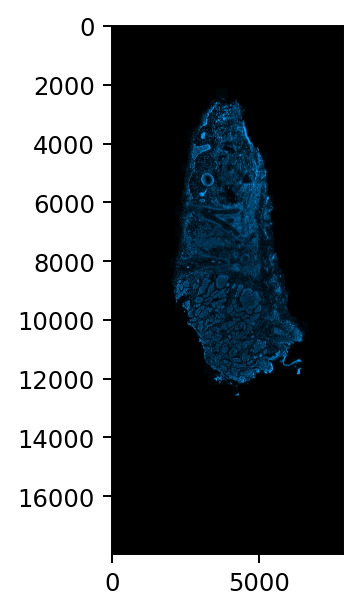

In [80]:
masked_all = cv2.bitwise_and(img_dapi1, img_dapi1, mask=np.array(fill_contour.astype('uint8')))
plt.imshow(masked_all)